# Red wine quality prediction

Re-formulated as a classification problem.

Apply weight on the objective function to balance data.

Test different loss functions.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

## Load the data

In [2]:
data = pd.read_csv('./data/winequality-red.csv')

## Pre-process the data

1. Check missing data - none
2. Drop the irrelevant columns - unecessary in this case
3. Ensure data types are correct
3. Encode the categorical columns
4. Normalize the continuous columns
5. Put back the categorical and continuous columns together
6. Split the data into a training set and a validation set

In [3]:
# only continuous columns exist
X_all = data.drop('quality', axis = 1).values
X_all = (X_all - X_all.mean()) / X_all.std()

# here, the wine quality is divided into 2 imbalanced groups to set up the classification problem
y_all = (data['quality'].values >= 7).astype(np.int32)
print(f'Good wines: {np.sum(y_all == 1)}, Bad wines: {np.sum(y_all == 0)}')

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.2, random_state = 0)

# convert stuff to torch tensors so they can be used in PyTorch training
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# check to make sure both classes are represeted in the training and test data
print(y_train.unique())
print(y_test.unique())

Good wines: 217, Bad wines: 1382
tensor([0, 1])
tensor([0, 1])


## Find the weight by counting the number of samples in each category

In [4]:
weight = [1/np.sum(y_all == 0), 1/np.sum(y_all == 1)]
#weight = [1,1]
print(weight)

[0.000723589001447178, 0.004608294930875576]


## Define the neural network architecture

In [5]:
class ANNModel(nn.Module):

    def __init__(self, in_size, out_size, hidden_sizes, p):
        super().__init__()

        layerlist = []
        for i in hidden_sizes:
            layerlist.append(nn.Linear(in_size,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            in_size = i
        layerlist.append(nn.Linear(hidden_sizes[-1], out_size))

        self.layers = nn.Sequential(*layerlist)

    def forward(self, x):
        x = self.layers(x)
        x = torch.log_softmax(x, dim = 1)
        return x

## Define other stuff needed to train the neural network model

In [6]:
torch.manual_seed(33)

# output size = 2, because the target has two classes
model = ANNModel(X_train.shape[1], 2, [5, 5, 3], p = 0.2)

# since this is a classification problem, use cross entropy loss
criterion = nn.CrossEntropyLoss(weight = torch.FloatTensor(weight))

# feed the data into the model by batches
train_dataloader = DataLoader([(X_train[i,:], y_train[i]) \
                               for i in range(X_train.shape[0])],
                               batch_size=512, shuffle=True)

# the optimizer to find weights
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# feed the data into the model by batches
batch_size = 300

# number of times to train the model
epochs = 300

# record the loss for each epoch
losses = []

## Train the model on training data

In [7]:
start_time = time.time()
for i in range(epochs):

    for j, (train_x, train_y) in enumerate(train_dataloader):
        # make a prediction
        y_pred = model(train_x)

        # calculate the loss and record it
        loss = criterion(y_pred, train_y)

        if j == 0:
            losses.append(loss.detach().numpy())
            # a neat trick to save screen space:
            if i%(int(epochs/10)) == 1:
                print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

        # set the gradients to zero
        optimizer.zero_grad()

        # calculate the gradients
        loss.backward()

        # let the optimizer update the weights
        optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.72135293
epoch:  31  loss: 0.69081283
epoch:  61  loss: 0.60213017
epoch:  91  loss: 0.50054157
epoch: 121  loss: 0.50006127
epoch: 151  loss: 0.52843153
epoch: 181  loss: 0.48977312
epoch: 211  loss: 0.48722032
epoch: 241  loss: 0.48204279
epoch: 271  loss: 0.48773202
epoch: 299  loss: 0.44766438

Duration: 12 seconds


Text(0.5, 0, 'epoch')

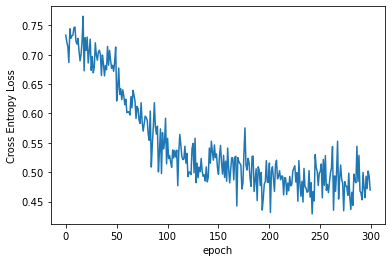

In [8]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch')

## Evaluate the model on the test set

In [9]:
# make sure to run model.eval(), or the random dropout will still be active
model.eval()
with torch.no_grad():
    y_val = model(X_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.53644294


In [10]:
rows = len(y_val)
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([-1.3043, -0.3166])    1      0   
tensor([-0.1269, -2.1273])    0      0   
tensor([-2.0935, -0.1315])    1      1   
tensor([-0.1756, -1.8262])    0      0   
tensor([-0.9943, -0.4620])    1      0   
tensor([-0.0787, -2.5815])    0      0   
tensor([-0.2019, -1.6991])    0      0   
tensor([-1.5945, -0.2269])    1      0   
tensor([-0.0787, -2.5815])    0      0   
tensor([-0.0787, -2.5815])    0      0   
tensor([-0.1402, -2.0341])    0      0   
tensor([-0.3119, -1.3171])    0      0   
tensor([-0.9483, -0.4901])    1      0   
tensor([-0.2100, -1.6637])    0      0   
tensor([-0.3541, -1.2101])    0      0   
tensor([-1.9903, -0.1469])    1      0   
tensor([-2.2205, -0.1149])    1      1   
tensor([-0.7904, -0.6045])    1      0   
tensor([-1.1756, -0.3691])    1      0   
tensor([-0.1129, -2.2371])    0      0   
tensor([-1.7606, -0.1887])    1      1   
tensor([-0.1663, -1.8761])    0      0   
tensor([-0.4201, -1.0700])    0   

In [11]:
rows = len(y_val)
correct = 0
ntot = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    if y_test[i] == 1:
        print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
        if y_val[i].argmax().item() == y_test[i]:
            correct += 1
        ntot += 1
print(f'\n{correct} out of {ntot} = {100*correct/ntot:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([-2.0935, -0.1315])    1      1   
tensor([-2.2205, -0.1149])    1      1   
tensor([-1.7606, -0.1887])    1      1   
tensor([-2.1422, -0.1249])    1      1   
tensor([-1.2449, -0.3396])    1      1   
tensor([-1.8284, -0.1751])    1      1   
tensor([-0.7378, -0.6504])    1      1   
tensor([-1.7317, -0.1948])    1      1   
tensor([-1.5339, -0.2430])    1      1   
tensor([-2.5742, -0.0793])    1      1   
tensor([-1.3597, -0.2967])    1      1   
tensor([-1.6694, -0.2087])    1      1   
tensor([-2.0353, -0.1400])    1      1   
tensor([-1.1382, -0.3862])    1      1   
tensor([-1.3204, -0.3106])    1      1   
tensor([-1.6694, -0.2087])    1      1   
tensor([-2.2601, -0.1102])    1      1   
tensor([-2.2908, -0.1067])    1      1   
tensor([-1.5895, -0.2282])    1      1   
tensor([-2.4689, -0.0885])    1      1   
tensor([-1.5884, -0.2285])    1      1   
tensor([-0.1417, -2.0242])    0      1   
tensor([-1.7960, -0.1815])    1   